## Group Name : Unfiltered Commentary
Raees Moosa : 2322203 \
Oriinga Maudu : 2433303 \
Tumi Jourdan : 2180153 

In [239]:
import cv2
import numpy as np
import skimage
import imageio
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from sklearn.cluster import KMeans
from tqdm import tqdm

Question 1 Filters

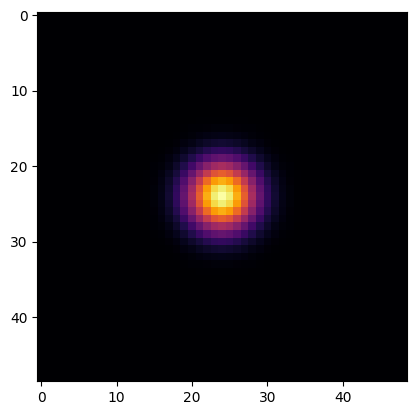

In [240]:
def GaussFilter(size, sigma):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    g = (1/(2*np.pi * sigma**2)) * np.exp(-(x**2 + y**2)/(2*sigma**2))
    #normalisng it - sometimes the sum is not perfectly 1...
    g /= np.sum(g)
    # print(np.sum(g))
    return g

test_gauss = GaussFilter(49, 10**0.5)
plt.imshow(test_gauss, cmap="inferno")

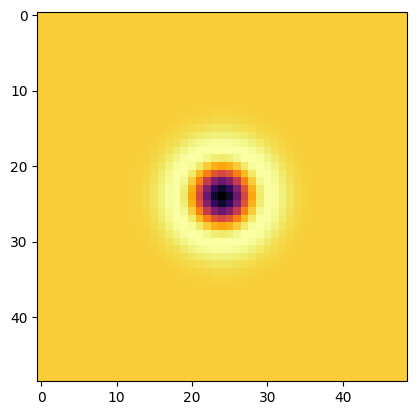

In [241]:
def LoG(size, sigma):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    
    g = -((1)/(np.pi * sigma ** 4 )) * \
        (1- (x**2 + y**2)/(2* sigma **2)) * \
        np.exp(-(x**2 + y**2)/(2*sigma**2))
    

    return g
test_log = LoG(49, 10**0.5)
plt.imshow(test_log,cmap="inferno")

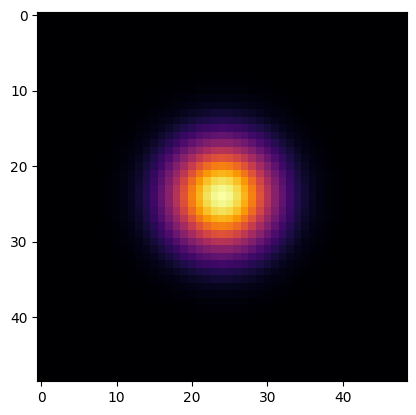

In [242]:
def DoG(size, sigma, K):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    
    g = ((1/(2 * np.pi * sigma **2)) * \
        np.exp(-(x**2 + y ** 2)/(2 * sigma **2))) - \
        ((1/ (2 * np.pi * K**2 *sigma**2)) * \
        np.exp(-(x**2 + y ** 2)/(2 * K**2 * sigma **2)))

    return g 
    

test_dog = DoG(49, 5, 10)
plt.imshow(test_dog,cmap="inferno")

Text(0.5, 1.0, 'dog')

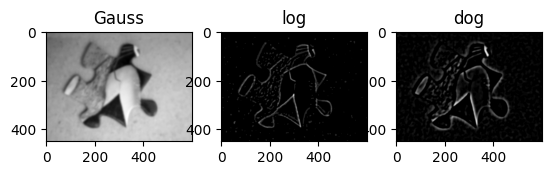

In [243]:
# Outputs for question 1
gauss = GaussFilter(49, 10**0.5)
lgauss =  LoG(49, 10**0.5)
dgauss = DoG(49,10**0.5,2)

image = cv2.imread('Images/image-35.jpg',cv2.IMREAD_GRAYSCALE)
# get gaussian 
gauss = cv2.filter2D(src=image, ddepth=-1, kernel = gauss)

# get log 
l_gauss = cv2.filter2D(src=image, ddepth=-1, kernel = lgauss)

# get dog
d_gauss = cv2.filter2D(src=image, ddepth=-1, kernel = dgauss)


plt.figure()
plt.subplot(1,3,1)
plt.imshow(gauss,cmap='gray')
plt.title("Gauss")

plt.subplot(1,3,2)
plt.imshow(l_gauss,cmap='gray')
plt.title("log")

plt.subplot(1,3,3)
plt.imshow(d_gauss,cmap='gray')
plt.title("dog")


Question 2


In [244]:
from scipy.ndimage import convolve

def create_gaussian_filter(theta, sigma_x, sigma_y, size, filter_type='edge'):
    # Create a grid of (x, y) coordinates
    x = np.linspace(-size//2+1, size//2, size)
    y = np.linspace(-size//2+1, size//2, size)
    x, y = np.meshgrid(x, y)
    # Rotate the coordinates
    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)
    
    # Calculate the Gaussian function f(xrot,sigmax)*f(yrot,sigmay)
    fx = np.exp(-0.5 * (x_rot**2 / sigma_x**2))/(np.sqrt(2 * np.pi) * sigma_x)
    fy = np.exp(-0.5 * (y_rot**2 / sigma_y**2))/(np.sqrt(2 * np.pi) * sigma_y)
    if filter_type == 'edge':
        # First derivative (edge)
        #x'
        dG_dx = fy*fx*(-x_rot/sigma_x**2)
        #y'
        dG_dy = fx*fy*(-y_rot/sigma_y**2)
        return dG_dx, dG_dy
    
    elif filter_type == 'bar':
        # Second derivative (bar)
        #x'
        d2G_dx2 = fy*fx*((x_rot**2-sigma_x**2)/sigma_x**4)
        #y'
        d2G_dy2 = fx*fy*((y_rot**2-sigma_y**2)/sigma_y**4)
        return d2G_dx2, d2G_dy2
    else:
        raise ValueError("Unknown filter type. Use 'edge' or 'bar'.")

def construct_rfs(debug: bool = False):
    sigma_x_sigma_y = np.array([(3,1),(6,2),(12,4)])
    thetas = np.array([0, 1/6*np.pi, 2/6*np.pi, 3/6*np.pi, 4/6*np.pi, 5/6*np.pi])

    size = (49, 49)

    rfs_edge = np.zeros((sigma_x_sigma_y.shape[0], thetas.shape[0], size[0], size[1]))
    rfs_bar = np.zeros((sigma_x_sigma_y.shape[0], thetas.shape[0], size[0], size[1]))

    for sigma_ind in range(sigma_x_sigma_y.shape[0]):
        for theta_ind in range(thetas.shape[0]):
            sigma = sigma_x_sigma_y[sigma_ind]
            theta = thetas[theta_ind]

            gaussian_edge = create_gaussian_filter(theta, sigma[0], sigma[1], size[0], 'edge')
            rfs_edge[sigma_ind, theta_ind] = gaussian_edge[1]
            gaussian_bar = create_gaussian_filter(theta, int(sigma[0]), sigma[1], size[0], 'bar')
            rfs_bar[sigma_ind, theta_ind] = gaussian_bar[1]

    # Combine rfs_edge and rfs_bar by concatenating along the theta axis
    rfs_combined = np.concatenate((rfs_edge, rfs_bar), axis=0)
    
    print(rfs_combined.shape)

    def plot_filters(filters, title, size=(49, 49)):
        rows, cols = filters.shape[:2]
        fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
        fig.suptitle(title, fontsize=16)
        
        for i in range(rows):
            for j in range(cols):
                ax = axes[i, j]
                ax.imshow(filters[i, j], cmap='inferno')
                ax.axis('off')
        
        plt.show()

    if debug:  
        plot_filters(rfs_combined, title="Combined Edge and Bar Filters (Y component)")
    
    return rfs_combined

def apply_rfs_filter_scipy(image, rfs_filters):
    max_responses = np.zeros((image.shape[0], image.shape[1], rfs_filters.shape[0] +2)) # plus 2 for the log and gauss

    for sigma_ind in range(rfs_filters.shape[0]):
        # Edge filters
        responses = []
        for theta_ind in range(rfs_filters.shape[1]):
            filter = rfs_filters[sigma_ind, theta_ind]
            response = convolve(image, filter)
            responses.append(response)
        
        max_responses[:, :, sigma_ind] = np.max(responses, axis=0)
    # now apply log and gauss and add them to the responses at the end of np array
    sigma = 10**0.5

    log_response = convolve(image,LoG(49, sigma))
    gauss_response = convolve(image,GaussFilter(49, sigma))
    max_responses[:,:,max_responses.shape[2]-2] = gauss_response
    max_responses[:,:,max_responses.shape[2]-1] = log_response
    
    return max_responses


(6, 6, 49, 49)


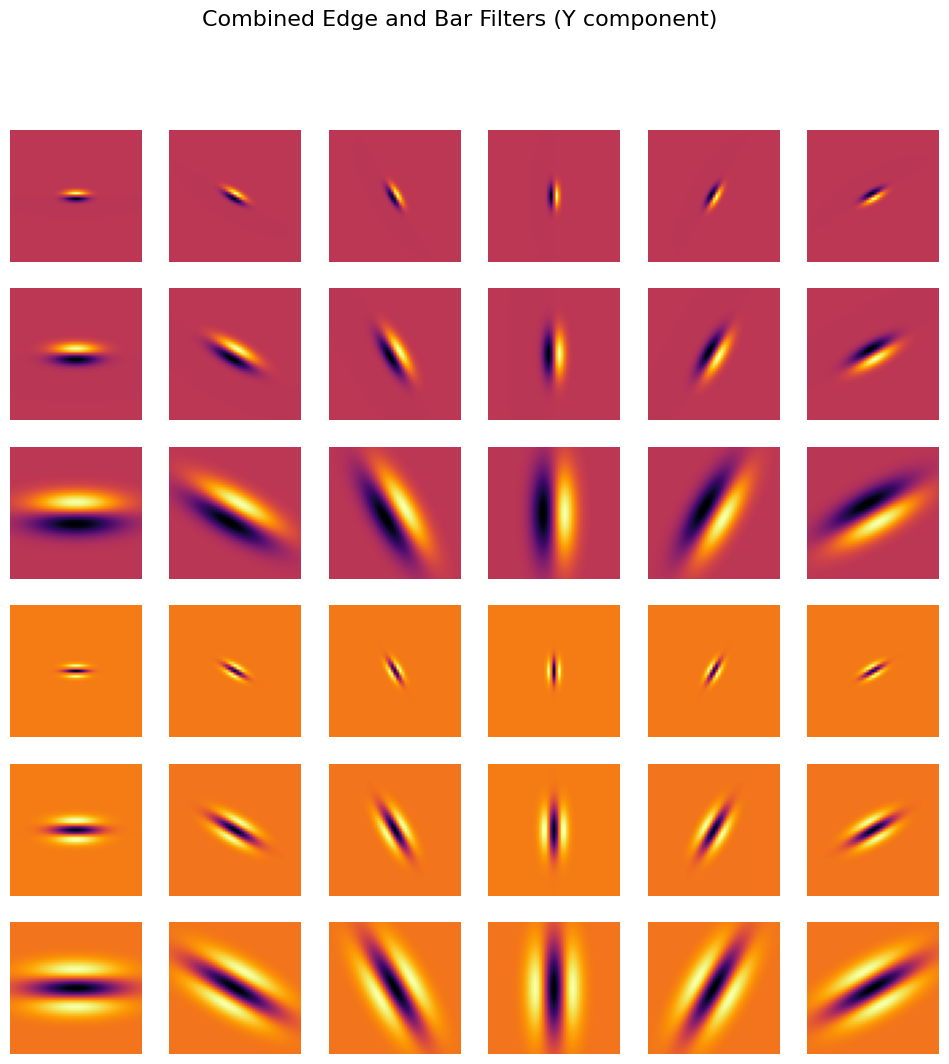

count 36


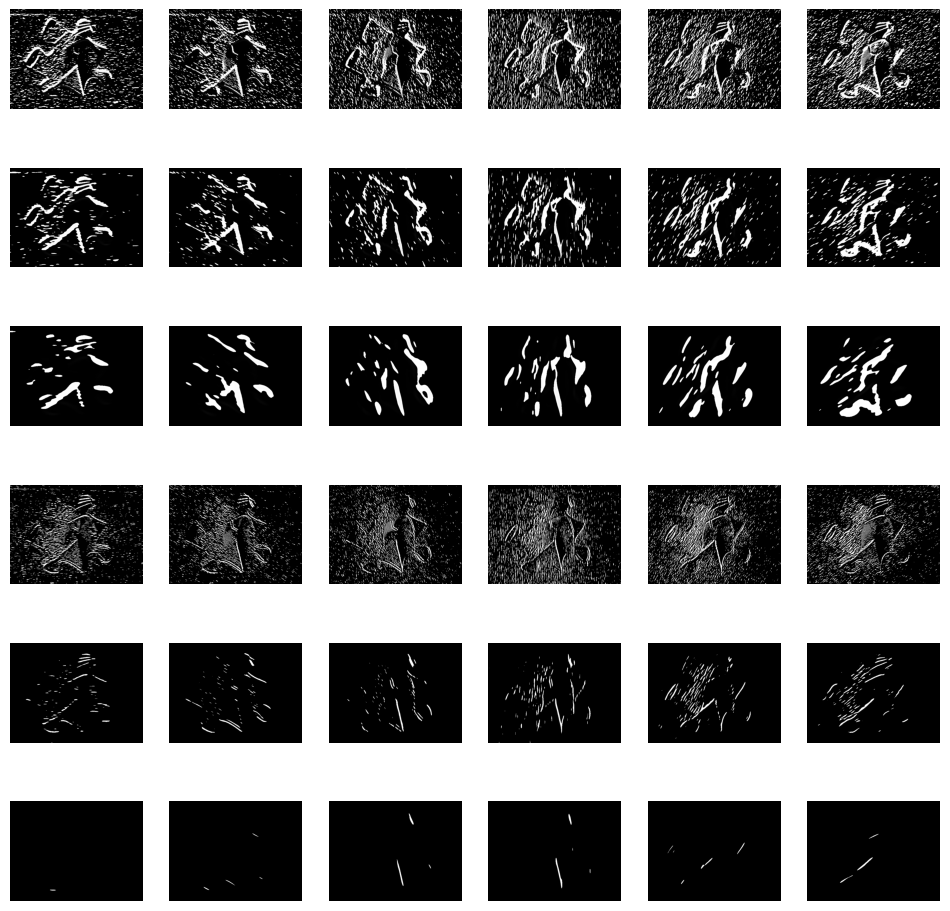

In [245]:
mr8_image = cv2.imread("Images/image-35.jpg", cv2.IMREAD_GRAYSCALE)
# print(mr8_image.shape)
rfs_filters = construct_rfs(debug=True)

responses = []
for sigma_ind in range(rfs_filters.shape[0]):
    for theta_ind in range(rfs_filters.shape[1]):
        response = convolve(mr8_image,rfs_filters[sigma_ind, theta_ind])
        responses.append(response)

    
print("count",len(responses))
rows = 6
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        ax.imshow(responses[i*cols +j ],cmap='gray')
        ax.axis('off')
        


In [246]:

mr8_image = cv2.imread("Images/image-35.jpg")
b,g,r = cv2.split(mr8_image)
b_response = apply_rfs_filter_scipy(b, rfs_filters)
g_response = apply_rfs_filter_scipy(g, rfs_filters)
r_response = apply_rfs_filter_scipy(r, rfs_filters)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


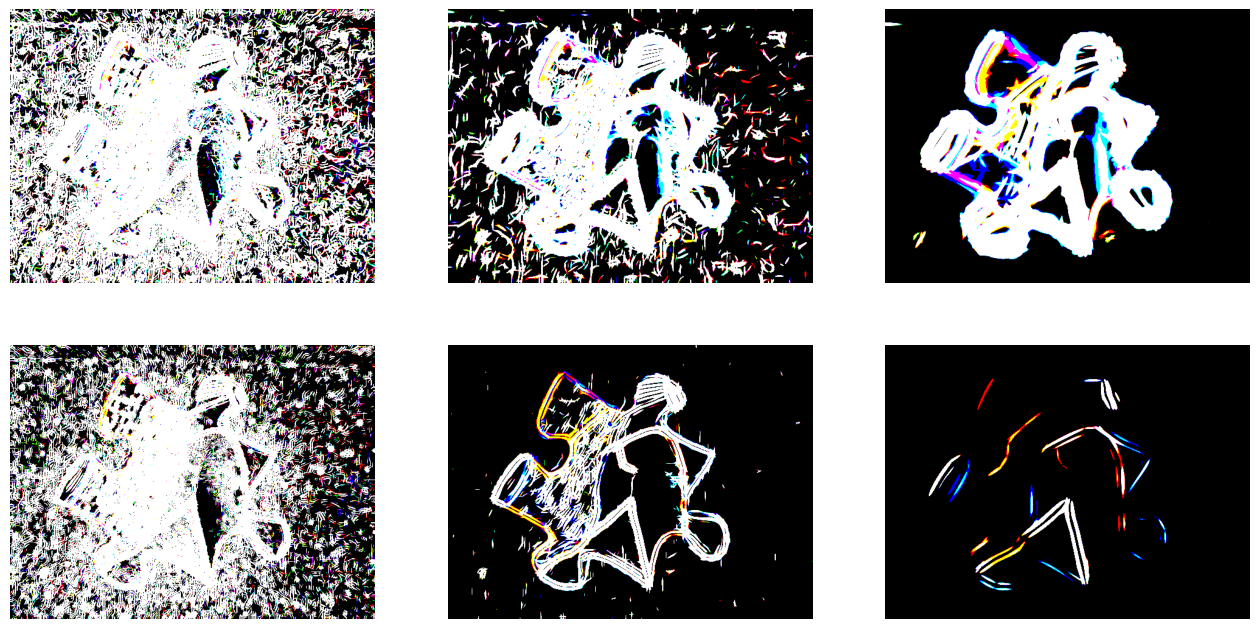

In [247]:

combined_responses = []

# Combine the responses for each filter (total of 6 filters)
for i in range(6):  # Assuming each response set has shape (H, W, 6)
    # Stack the R, G, B responses into a single RGB image
    combined_rgb = cv2.merge((b_response[:, :, i], g_response[:, :, i], r_response[:, :, i]))
    combined_responses.append(combined_rgb)

fig, axes = plt.subplots(nrows = 2, ncols= 3, figsize=(16,8), sharex= True, sharey = True)
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.imshow(combined_responses[i-1])
    plt.axis("off")

Question 3

In [248]:
def getLBPs(img,show_plot=False):
    lbps = []
    radii = [4, 8, 16, 24, 32]
    for radius in radii:
        lbp = skimage.feature.local_binary_pattern(img,12,radius,'uniform')
        lbps.append(lbp)

    if show_plot:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i, (img, label) in enumerate(zip(lbps, radii)):
            axes[i].imshow(img, cmap="gray")
            axes[i].axis('off')
            axes[i].set_title(label)  

        plt.tight_layout()
        plt.show()

    return np.array(lbps)

In [249]:
def apply_haar_filter(integral_images, filter_size,show_plot=False):
    h, w = integral_images[0].shape
    # integral images have a buffer at the end of each axis
    h= h-1
    w= w-1
    response = np.zeros((len(integral_images),h,w))
    
    for i in range(len(integral_images)):  # For each channel (R, G, B)
        integral_image = integral_images[i]
        
        for y in range(h):
            for x in range(w):
                A = integral_image[max(0,y - filter_size//2),max(0,x - filter_size//2)]
                B = integral_image[max(0,y - filter_size//2),min(w,x + filter_size//2)]
                C = integral_image[min(h,y + filter_size//2),max(0,x - filter_size//2)]
                D = integral_image[min(h,y + filter_size//2), min(w,x + filter_size//2)]
                
                pos_sum = A + D
                
                neg_sum = B + C
                
                response[i,y,x] = pos_sum - neg_sum

    if show_plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i  in range(response.shape[0]):
            axes[i].imshow(response[i].astype(np.uint8), cmap = 'gray' )
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
                
    return response

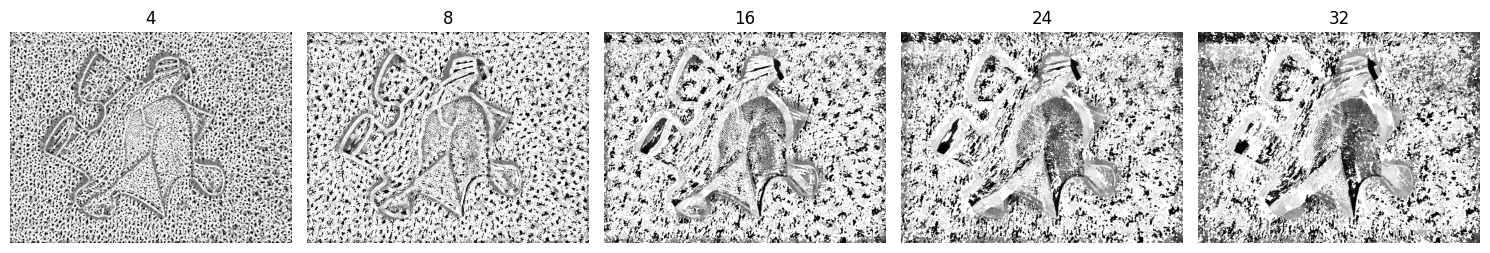

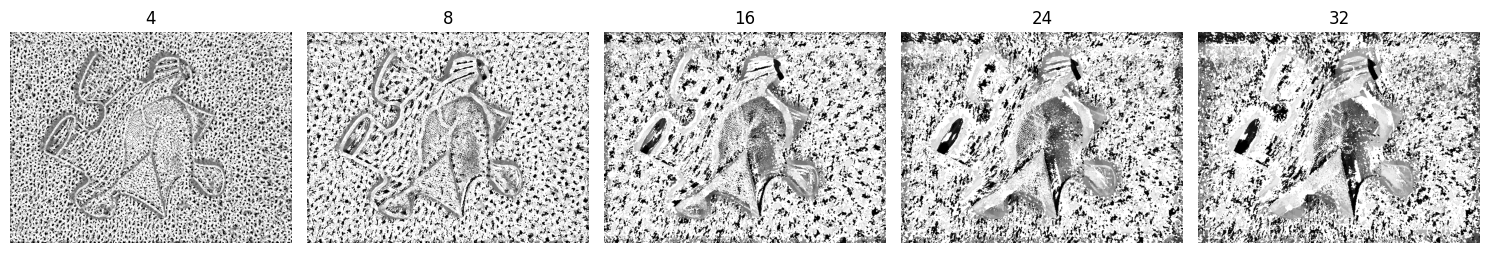

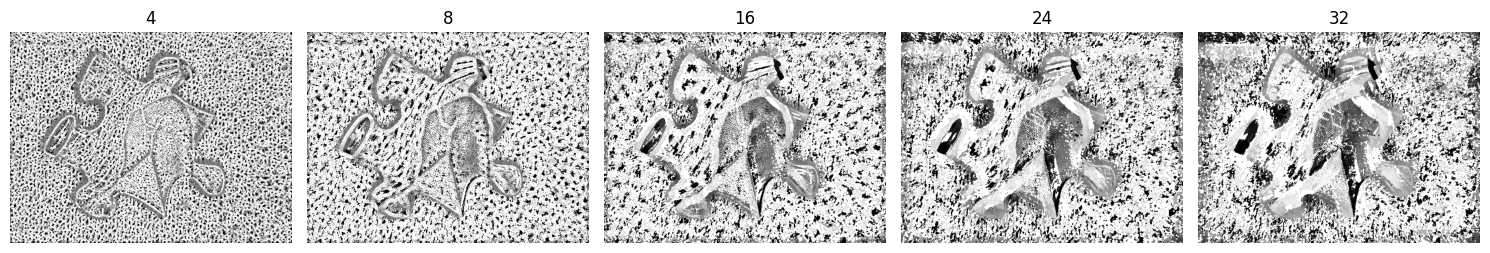

(450, 600)
(450, 600)
(450, 600)


In [250]:
img = cv2.imread('Images/image-35.jpg')
red, green, blue = cv2.split(img)

red_lbps = getLBPs(red,show_plot=True)
green_lbps = getLBPs(green,show_plot=True)
blue_lbps = getLBPs(blue,show_plot=True)
print(red_lbps[0].shape)
print(green_lbps[0].shape)
print(blue_lbps[0].shape)

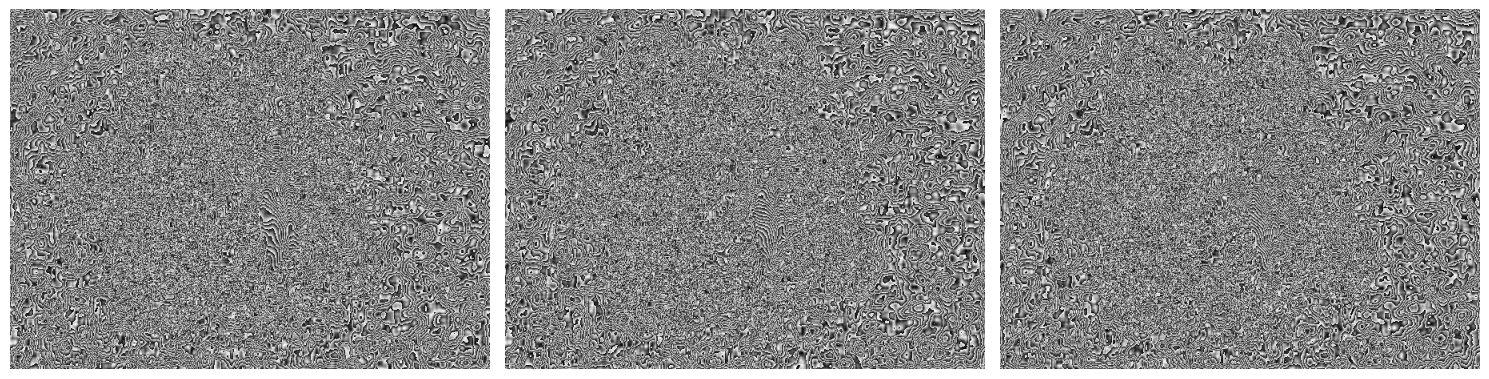

(3, 450, 600)
(3, 450, 600)
(3, 450, 600)


In [251]:
img = cv2.imread('Images/image-35.jpg')
integral_images =[cv2.integral(img[:, :, i]) for i in range(3)]

haar_response4 = apply_haar_filter(integral_images,4,True)
haar_response8 = apply_haar_filter(integral_images,8,True)
haar_response16 = apply_haar_filter(integral_images,16,True)
print(haar_response4.shape)
print(haar_response8.shape)
print(haar_response16.shape)

Section 4

In [263]:
from scipy.stats import multivariate_normal
from sklearn.preprocessing import OneHotEncoder

class Stat_Classifier:

    def __init__(self,image) -> None:
        self.image = image
        self.kmeans = None
        pass

    def classify(self, validation_features, fg_features, bg_features, train_mask, train_image):
        # Compute the means and covariances for foreground and background
        fg_feature_matrix = np.stack(fg_features, axis=-1)
        fg_mean_vector = np.mean(fg_feature_matrix, axis=0)
        fg_cov_matrix = np.cov(fg_feature_matrix, rowvar=False)

        bg_feature_matrix = np.stack(bg_features, axis=-1)
        bg_mean_vector = np.mean(bg_feature_matrix, axis=0)
        bg_cov_matrix = np.cov(bg_feature_matrix, rowvar=False)

        print("Features extracted from original")

        # Reshape the validation features for pixel-wise processing
        reshaped_features = validation_features.T
        print("Reshaped the test features")

       
        probabilities = self.foreground_given_pixel(reshaped_features, fg_mean_vector, fg_cov_matrix, 
                                                        bg_mean_vector, bg_cov_matrix,mask,image)
        print("Computed the feature array probabilities")
        return probabilities.reshape((450,600))


    
    def foreground_given_pixel(self,x,fg_mean, fg_cov, bg_mean, bg_cov,mask,image):
        """
        Args:
            mask (2d array): Remember to binarize it.
            image (type):the original image.

        Returns:
            type: probability.
        """
        N = image.shape[0]*image.shape[1]
        N_fg = np.sum(mask)
        N_bg = N - N_fg
        
        numerator = multivariate_normal.pdf( x, mean = fg_mean, cov= fg_cov, allow_singular=True) * (N_fg)
        denominator = multivariate_normal.pdf(x, mean=fg_mean, cov=fg_cov, allow_singular=True)*N_fg \
                    + multivariate_normal.pdf( x, mean= bg_mean, cov= bg_cov, allow_singular=True) * (N_bg)
        small_value = 1e-10  # You can adjust the small value if needed
        denominator = np.where(denominator == 0, small_value, denominator)
        probability = numerator/denominator
        return probability
    
    def getFeatures(self,training_img, mask, show_plot=False,MR8:bool = False, texton:bool = False, desired_sigma = 10**0.5,feature_matrix = [1,1,1,1,1,1]):
        """
        Parameters:
            training_img (2d array): training image.
            mask (type): binarized image.

        Returns:
            type: Flattened features.
        """
        if(type(mask[0][0]) != np.bool_):
            binary_mask = mask >128

        vertical_prewitt = np.array([
            [1,1,1],
            [0,0,0],
            [-1,-1,-1]
        ])
        horizontal_prewitt = np.array([
            [1,0,-1],
            [1,0,-1],
            [1,0,-1]
        ])

        laplacian = np.array([
            [0,-1,0],
            [-1,4,-1],
            [0,-1,0]
        ])
        # ceil(6*sigma) x ceil(6*sigma)
        
        kernel_size = np.ceil(6*desired_sigma)**2
        gauss = GaussFilter(kernel_size, desired_sigma)
        lgauss =  LoG(kernel_size, desired_sigma)
        dgauss = DoG(kernel_size,desired_sigma,2)

        binary_mask = mask>128
        #plt.imshow(binary_mask)
        
        #add dimensions
        # print(binary_mask.shape)
        hsv_training_img = cv2.cvtColor(training_img, cv2.COLOR_BGR2RGB)
        v,s,h = cv2.split(hsv_training_img)
        h, s,v = h*binary_mask, s*binary_mask, v*binary_mask
        # print(h.shape)
        b,g,r = cv2.split(training_img)
        r,g,b = r*binary_mask, g*binary_mask, b*binary_mask


        # get vertical prewitt for separated channels

        vert_prewitt_r = cv2.filter2D(src=r, ddepth=-1, kernel=vertical_prewitt)
        vert_prewitt_g = cv2.filter2D(src=g, ddepth=-1, kernel=vertical_prewitt)
        vert_prewitt_b = cv2.filter2D(src=b, ddepth=-1, kernel=vertical_prewitt)
        # get horizontal prewitt for separated channels

        hori_prewitt_r = cv2.filter2D(src=r, ddepth=-1, kernel=horizontal_prewitt)
        hori_prewitt_g = cv2.filter2D(src=g, ddepth=-1, kernel=horizontal_prewitt)
        hori_prewitt_b = cv2.filter2D(src=b, ddepth=-1, kernel=horizontal_prewitt)
        # get Laplacian for separated channels

        laplace_r = cv2.filter2D(src=r, ddepth=-1, kernel=laplacian)
        laplace_g = cv2.filter2D(src=g, ddepth=-1, kernel=laplacian)
        laplace_b = cv2.filter2D(src=b, ddepth=-1, kernel=laplacian)

        # get gaussian for seperate channels
        gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = gauss)
        gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = gauss)
        gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = gauss)

        # get log of gaussian for seperate channels
        l_gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = lgauss)
        l_gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = lgauss)
        l_gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = lgauss)

        # get log of gaussian for seperate channels
        d_gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = dgauss)
        d_gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = dgauss)
        d_gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = dgauss)

        # get LBPs for seperate channels
        lbp_r = getLBPs(r)
        lbp_g = getLBPs(g)
        lbp_b = getLBPs(b)

        # get Harr for seperate channels and sizes
        integral_images = [cv2.integral(training_img[:,:,i]) for i in range(3)]
        haar4 = apply_haar_filter(integral_images,4)
        haar8 = apply_haar_filter(integral_images,8)
        haar16 = apply_haar_filter(integral_images,16)

        if show_plot:
            # vertical prewitt plot 
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( vert_prewitt_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( vert_prewitt_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( vert_prewitt_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Vertical Prewitt of RGB image")
            plt.show()

            # horizontal prewitt plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( hori_prewitt_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( hori_prewitt_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( hori_prewitt_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Horizontal Prewitt of RGB image")
            plt.show()

            # laplace plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( laplace_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( laplace_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( laplace_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Laplacian of RGB image")
            plt.show()

            # gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Gaussian of RGB image")
            plt.show()


            # log of gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( l_gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( l_gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( l_gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Log of Gaussian of RGB image")
            plt.show()

            # difference of gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( d_gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( d_gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( d_gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Difference of Gaussian of RGB image")
            plt.show()

            # LBP Red plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_r, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Red image")
            plt.show()

            # LBP Green plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_g, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Green image")
            plt.show()

            # LBP Blue plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_b, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Blue image")
            plt.show()

            # Haar4 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar4.shape[0]):
                axes[i].imshow(haar4[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 4 of RGB image")
            plt.show()

            # Haar8 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar8.shape[0]):
                axes[i].imshow(haar8[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 8 of RGB image")
            plt.show()

            # Haar16 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar16.shape[0]):
                axes[i].imshow(haar16[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 16 of RGB image")
            plt.show()

        
        features = []
        if (feature_matrix[0]):
            features.extend([ vert_prewitt_r, hori_prewitt_r, 
                vert_prewitt_g, hori_prewitt_g, 
                vert_prewitt_b, hori_prewitt_b, 
                laplace_r, laplace_g, laplace_b,])            
        if (feature_matrix[1]):   
            features.extend([gauss_r, l_gauss_r, d_gauss_r,
                gauss_g, l_gauss_g, d_gauss_g,
                gauss_b, l_gauss_b, d_gauss_b,])
        if (feature_matrix[2]):    
            features.extend([lbp_r[0],lbp_r[1],lbp_r[2],lbp_r[3],lbp_r[4],
                lbp_g[0],lbp_g[1],lbp_g[2],lbp_g[3],lbp_g[4],
                lbp_b[0],lbp_b[1],lbp_b[2],lbp_b[3],lbp_b[4],])
        if (feature_matrix[3]):    
            features.extend([haar4[0],haar4[1],haar4[1],
                haar8[0],haar8[1],haar8[1],
                haar16[0],haar16[1],haar16[1],])    
        if (feature_matrix[4]):    
            features.extend([r, g, b,])
        if (feature_matrix[5]):
            features.extend([ h, s, v,])
        

        flattened_features = np.array([f[binary_mask].flatten() for f in features]) 
        print("Shape of flattened_features before texton:", flattened_features.shape)
        if texton:
           
            textons = self.textons(image, mask)

            # One-hot encode the textons
            encoder = OneHotEncoder(categories=[range(4)], sparse_output=False)
            textons_one_hot = encoder.fit_transform(textons.flatten().reshape(-1, 1))


            # Transpose filtered_textons to get the shape 
            filtered_textons = textons_one_hot.T  

            print("Shape of filtered_textons:", filtered_textons.shape)

            # Concatenate along the features axis (features should be appended)
            concatenated_features = np.concatenate([flattened_features, filtered_textons], axis=0)

            print("Shape of concatenated_features:", concatenated_features.shape)



        return np.array(flattened_features)
    
    def textons(self, image, mask, plot=False):
        original_features = self.getFeatures(image, mask, False)
        print(original_features.shape)
        
        perpixel_features = np.swapaxes(original_features, 0, 1)
        print("Clustering!")
        
        # mask_flattened = mask.flatten()
        # masked_features = perpixel_features[mask_flattened]
        
        kmeans = KMeans(n_clusters=4, random_state=42).fit(perpixel_features)
        textons_intern = kmeans.labels_
        
             
        if plot:
            plt.imshow(textons_intern.reshape(mask.shape))
            plt.show()
        
        return textons_intern

    def dummy_test(self, image_path):
        # Mask,inverse and image (original in the lab1)

        # Example usage within the dummy_test or other testing functions:
        image = cv2.imread("Images/image-35.jpg")
        mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
        inverse_mask = 255 - mask 
        class_inst = Stat_Classifier(image)

        # Extract textons from the training image
        # train_textons = class_inst.textons(image, )

        # Validation features
        null = np.ones_like(mask) * 255
        validation_img = cv2.imread("Images/image-83.jpg")

        validation_features = class_inst.getFeatures(validation_img, null, show_plot=False, texton=True)
        fg_features = class_inst.getFeatures(image, mask, show_plot=False, texton=True)
        bg_features = class_inst.getFeatures(image, inverse_mask, show_plot=False, texton=True)

        # Extract textons for the validation image
        # validation_textons = class_inst.textons(validation_img, null)

        # Classify 
        verify_img = class_inst.classify(validation_features, fg_features, bg_features, mask, image)
        theta = 0.5
        thresholded_img = verify_img.copy() > theta
        plt.figure()
        plt.imshow(thresholded_img, cmap="gray"), plt.title("Validation image prediction")
        plt.show()
        return verify_img

        # accuracy

    


### 4.2 Find and display Textons


Shape of flattened_features before texton: (48, 270000)
(48, 270000)


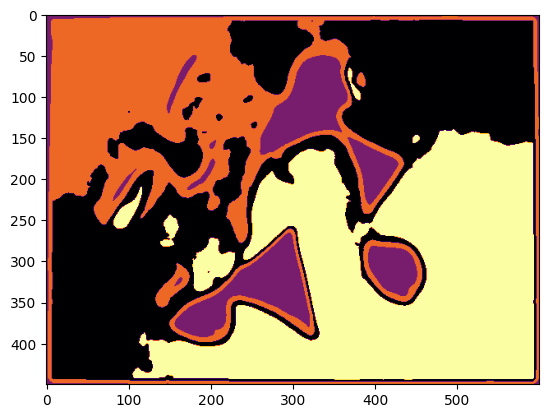

In [264]:

image = cv2.imread("Images/image-35.jpg")
mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
classify_inst = Stat_Classifier(image)
null = np.ones_like(mask)*255
original_features = classify_inst.getFeatures(image,null,False)
print(original_features.shape)

perpixel_features = np.swapaxes(original_features,0,1)

kmeans = KMeans(n_clusters=4, random_state=42).fit(perpixel_features)
textons = kmeans.labels_
plt.imshow(textons.reshape(450,600), cmap="inferno")

### 4.3 Testing model accuracy on test Image

(450, 600, 3)
classifying the test image
Shape of flattened_features before texton: (48, 270000)
Shape of flattened_features before texton: (48, 270000)
(48, 270000)
Clustering!
Shape of filtered_textons: (4, 270000)
Shape of concatenated_features: (52, 270000)
Shape of flattened_features before texton: (48, 74571)
Shape of flattened_features before texton: (48, 74571)
(48, 74571)
Clustering!
Shape of filtered_textons: (4, 74571)
Shape of concatenated_features: (52, 74571)
Shape of flattened_features before texton: (48, 195424)
Shape of flattened_features before texton: (48, 195424)
(48, 195424)
Clustering!
Shape of filtered_textons: (4, 195424)
Shape of concatenated_features: (52, 195424)
Features extracted from original
Reshaped the test features
Computed the feature array probabilities


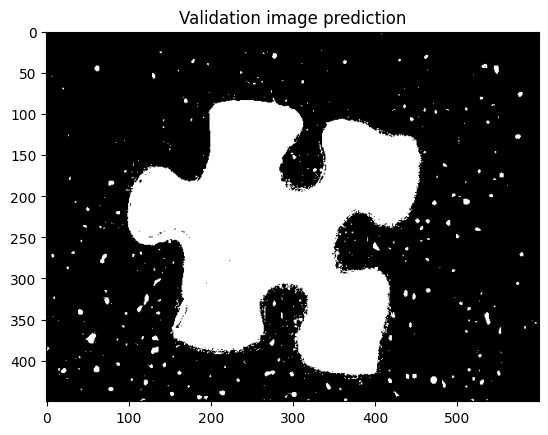

In [254]:
test_image = cv2.imread("Images/image-83.jpg")
image = cv2.imread("Images/image-35.jpg")
print(test_image.shape)
mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
null = np.ones_like(mask)*255

classify_inst = Stat_Classifier(image)

print("classifying the test image")
test_img_result = classify_inst.dummy_test("Images/image-83.jpg")


#### Accuracy using textons - IOU SCORE

In [255]:
from sklearn.metrics import confusion_matrix
test_mask = cv2.imread("Images/mask-83.png", cv2.IMREAD_GRAYSCALE)
def get_IOU_PosNeg(img1,img2):
    conf_matrix = confusion_matrix((img1 >0.99).astype(int).flatten(), (img2 >0.99).astype(int).flatten())
    TN = conf_matrix[0][0]
    fn = conf_matrix[1][0]
    tp = conf_matrix[1][1]
    fp = conf_matrix[0][1]
    iou = tp / (tp + fp + fn)

    return iou
print(get_IOU_PosNeg(test_mask, test_img_result))

0.8281889785202214


### 4.4 Using MR8 for classifier

Shape of flattened_features before texton: (48, 270000)
Shape of flattened_features before texton: (48, 270000)
(48, 270000)
Clustering!
Shape of filtered_textons: (4, 270000)
Shape of concatenated_features: (52, 270000)
Shape of flattened_features before texton: (48, 74571)
Shape of flattened_features before texton: (48, 74571)
(48, 74571)
Clustering!
Shape of filtered_textons: (4, 74571)
Shape of concatenated_features: (52, 74571)
Shape of flattened_features before texton: (48, 195424)
Shape of flattened_features before texton: (48, 195424)
(48, 195424)
Clustering!
Shape of filtered_textons: (4, 195424)
Shape of concatenated_features: (52, 195424)
Features extracted from original
Reshaped the test features
Computed the feature array probabilities


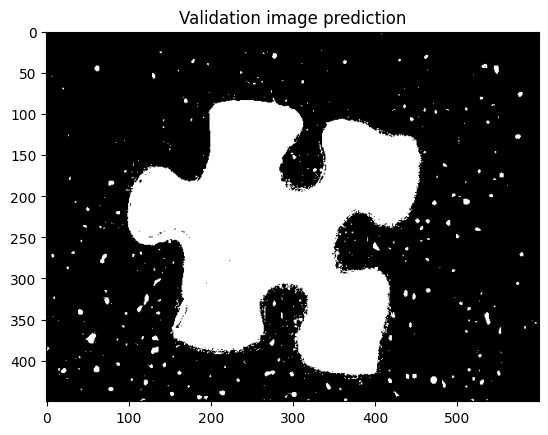

In [256]:
image = cv2.imread("Images/image-35.jpg")
mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
inverse_mask = 255 - mask 
class_inst = Stat_Classifier(image)


# Validation features
null = np.ones_like(mask) * 255
validation_img = cv2.imread("Images/image-83.jpg")

validation_features = class_inst.getFeatures(validation_img, null, show_plot=False,MR8= True, texton=True)
fg_features = class_inst.getFeatures(image, mask, show_plot=False,MR8= True, texton=True)
bg_features = class_inst.getFeatures(image, inverse_mask, show_plot=False,MR8= True, texton=True)



# Classify 
verify_img = class_inst.classify(validation_features, fg_features, bg_features, mask, image)
theta = 0.5
thresholded_img = verify_img.copy() > theta
plt.figure()
plt.imshow(thresholded_img, cmap="gray"), plt.title("Validation image prediction")
plt.show()

#### Accuracy of MR8 + TExtons - IOU SCORE

In [257]:
test_mask = cv2.imread("Images/mask-83.png", cv2.IMREAD_GRAYSCALE)
print(get_IOU_PosNeg(test_mask, verify_img))

0.8281889785202214


Question 4.5

In [258]:
import sklearn.linear_model


image = cv2.imread("Images/image-35.jpg")
mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
mask = mask>=127.5
null = np.ones_like(mask)*255

classify_inst = Stat_Classifier(image)

original_features = classify_inst.getFeatures(image,null,False,MR8=True)

perpixel_features = np.swapaxes(original_features,0,1)

log_reg = sklearn.linear_model.LogisticRegression().fit(perpixel_features,mask.flatten())

Shape of flattened_features before texton: (48, 270000)


c:\Users\Tumi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Shape of flattened_features before texton: (48, 270000)
Shape of flattened_features before texton: (48, 270000)
(48, 270000)
Clustering!
Shape of filtered_textons: (4, 270000)
Shape of concatenated_features: (52, 270000)
Accuracy 0.9646851851851852
(270000,)


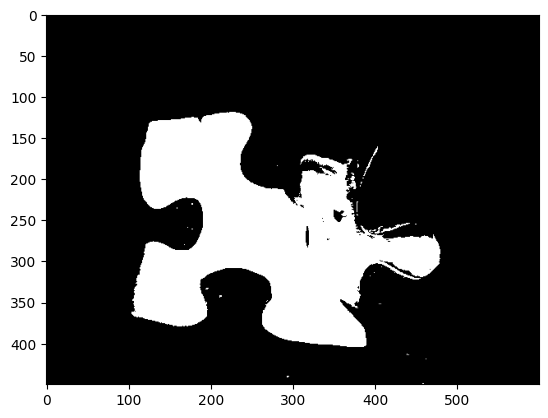

In [265]:


ver = cv2.imread("Images/image-110.jpg")
mask = cv2.imread("Images/mask-110.png", cv2.IMREAD_GRAYSCALE)
mask = mask>=127.5
ver_features = classify_inst.getFeatures(ver,null,False,MR8=True,texton=True)
ver_perpixel_features = np.swapaxes(ver_features,0,1)

predictions = log_reg.predict(ver_perpixel_features)
print("Accuracy", log_reg.score(ver_perpixel_features,mask.flatten()))

print(predictions.shape)

plt.imshow(predictions.reshape(450,600),cmap = 'gray')

In [ ]:
from itertools import product

# Length of the boolean array
n = 6

# Generate all possible combinations of 0s and 1s
combinations = list(product([0, 1], repeat=n))

# Convert tuples to lists
combinations = [list(comb) for comb in combinations]
accuracies = []
# Print the combinations
for comb in combinations:
    ver = cv2.imread("Images/image-110.jpg")
    mask = cv2.imread("Images/mask-110.png", cv2.IMREAD_GRAYSCALE)
    mask = mask>=127.5
    ver_features = classify_inst.getFeatures(ver,null,False,MR8=True,texton=True,feature_matrix=comb)
    ver_perpixel_features = np.swapaxes(ver_features,0,1)

    predictions = log_reg.predict(ver_perpixel_features)
    print("Accuracy", log_reg.score(ver_perpixel_features,mask.flatten()))
    accuracies.append(log_reg.score(ver_perpixel_features,mask.flatten()))
    print(predictions.shape)
    plt.imshow(predictions.reshape(450,600),cmap = 'gray')
    plt.show()
print(accuracies)